In [9]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import sklearn, pandas
import librosa, librosa.display

In [10]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

[&larr; Back to Index](index.html)

# Genre Recognition

## Load Audio

Load 30 seconds of an audio file:

In [11]:
filename_brahms = 'audio/brahms_hungarian_dance_5.mp3'
x_brahms, sr_brahms = librosa.load(filename_brahms, duration=30)

Load 30 seconds of another audio file:

In [12]:
filename_busta = 'audio/busta_rhymes_hits_for_days.mp3'
x_busta, sr_busta = librosa.load(filename_busta, duration=30)

Play the audio files:

In [13]:
ipd.Audio(x_brahms, rate=sr_brahms)

In [14]:
ipd.Audio(x_busta, rate=sr_busta)

Plot the time-domain waveform of the audio signals:

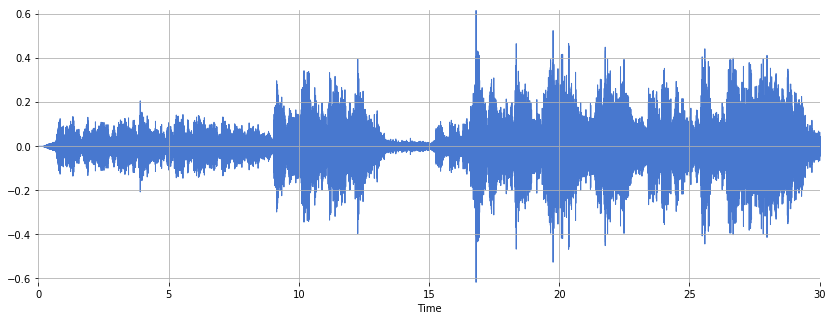

In [15]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x_brahms, sr_brahms)

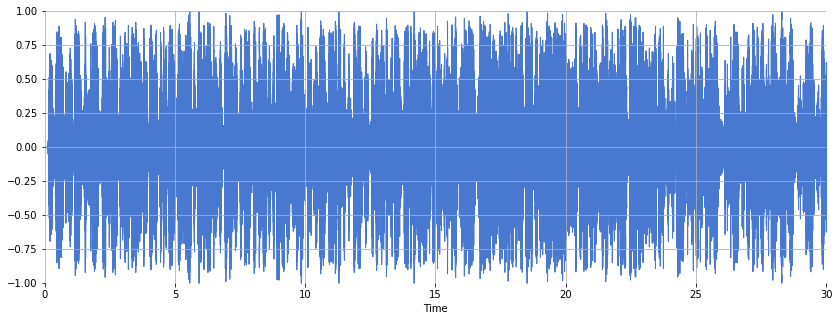

In [16]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x_busta, sr_busta)

Compute the power melspectrogram:

In [17]:
S_brahms = librosa.feature.melspectrogram(x_brahms, sr=sr_brahms, power=2.0)

Convert amplitude to decibels:

In [18]:
Sdb_brahms = librosa.power_to_db(S_brahms)

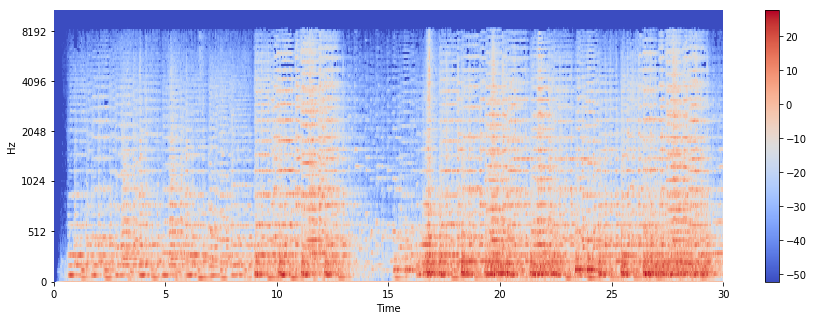

In [19]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(Sdb_brahms, sr=sr_brahms, x_axis='time', y_axis='mel')
plt.colorbar()

In [20]:
S_busta = librosa.feature.melspectrogram(x_busta, sr=sr_busta, power=2.0)
Sdb_busta = librosa.power_to_db(S_busta)

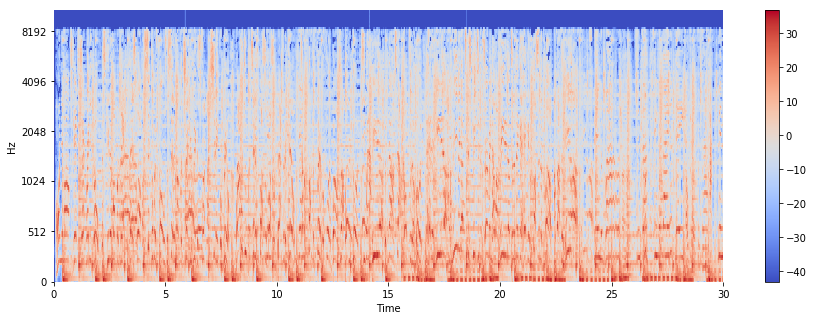

In [21]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(Sdb_busta, sr=sr_busta, x_axis='time', y_axis='mel')
plt.colorbar()

In what ways do the time-domain waveform and spectrogram differ between the two files? What differences in musical attributes might this reflect? What additional insights are gained from plotting the spectrogram?

## Extract Features

For each segment, compute the MFCCs. Experiment with `n_mfcc` to select a different number of coefficients, e.g. 12.

In [22]:
n_mfcc = 12
mfcc_brahms = librosa.feature.mfcc(x_brahms, sr=sr_brahms, n_mfcc=n_mfcc).T

We transpose the result to accommodate scikit-learn which assumes that each row is one observation, and each column is one feature dimension:

In [23]:
mfcc_brahms.shape

(1292, 12)

In [24]:
mfcc_brahms.mean(axis=0)

array([-221.18246533,  135.71436909,  -16.2076221 ,   60.08282523,
        -10.7576358 ,   24.58042774,  -10.07175902,    9.7418781 ,
         -8.29413472,    5.64488819,   -3.99779736,   -2.94005158])

In [25]:
mfcc_brahms.std(axis=0)

array([78.52242746, 19.23684866, 14.44447074, 11.17408373, 11.15110539,
        9.54755265,  8.30942512,  8.35251267,  8.34751264,  7.32610545,
        6.03185251,  5.75477889])

Scale the features to have zero mean and unit variance:

In [26]:
scaler = sklearn.preprocessing.StandardScaler()

In [27]:
mfcc_brahms_scaled = scaler.fit_transform(mfcc_brahms)
# is equivalent to:
#  scaler.fit(mfcc_brahms)
#  mfcc_brahms_scaled = scaler.transform(mfcc_brahms)

Verify that the scaling worked:

In [28]:
mfcc_brahms_scaled.mean(axis=0)

array([ 7.26628939e-16,  4.94633574e-15,  1.28010777e-15,  5.86630847e-15,
       -2.25911481e-16,  1.28380279e-15, -4.58052928e-16,  7.71140977e-16,
        1.73175887e-15,  1.04955604e-15,  3.98030422e-16,  3.05955811e-16])

In [29]:
mfcc_brahms_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Extract MFCCs from the second audio file.

In [30]:
mfcc_busta = librosa.feature.mfcc(x_busta, sr=sr_busta, n_mfcc=n_mfcc).T

We transpose the resulting matrix so that each row is one observation, i.e. one set of MFCCs. Note that the shape and size of the resulting MFCC matrix is equivalent to that for the first audio file:

In [31]:
print(mfcc_brahms.shape)
print(mfcc_busta.shape)

(1292, 12)
(1292, 12)


Scale the resulting MFCC features to have approximately zero mean and unit variance. Re-use the scaler from above.

In [32]:
mfcc_busta_scaled = scaler.transform(mfcc_busta)

Verify that the mean of the MFCCs for the second audio file is approximately equal to zero and the variance is approximately equal to one.

In [33]:
mfcc_busta_scaled.mean(axis=0)

array([ 2.25120306, -0.96555404, -1.01020874, -0.6193046 , -2.07566536,
        0.70153854, -0.99536975,  1.37606878, -1.19486033,  0.98245431,
       -1.05705989,  1.65750508])

In [34]:
mfcc_busta_scaled.std(axis=0)

array([0.64509534, 1.25286427, 1.30271149, 1.46822723, 1.4941753 ,
       1.66072955, 1.65563535, 1.50140628, 1.26480836, 1.3169426 ,
       1.64734603, 1.63916419])

## Train a Classifier

Concatenate all of the scaled feature vectors into one feature table.

In [35]:
features = numpy.vstack((mfcc_brahms_scaled, mfcc_busta_scaled))

In [36]:
features.shape

(2584, 12)

Construct a vector of target/reference labels, where 0 refers to the first audio file, and 1 refers to the second audio file.

In [37]:
labels = numpy.concatenate((numpy.zeros(len(mfcc_brahms_scaled)), numpy.ones(len(mfcc_busta_scaled))))

In [38]:
labels.shape

(2584,)

Create a classifer model object:

In [39]:
# Support Vector Machine
model = sklearn.svm.SVC()

Train the classifier:

In [40]:
model.fit(features, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Run the Classifier

To test the classifier, we will extract an unused 10-second segment from the earlier audio fields as test excerpts:

In [41]:
x_brahms_test, sr_brahms = librosa.load(filename_brahms, duration=10, offset=120)

In [42]:
x_busta_test, sr_busta = librosa.load(filename_busta, duration=10, offset=120)

Listen to both of the test audio excerpts:

In [43]:
ipd.display( ipd.Audio(x_brahms_test, rate=sr_brahms) )
ipd.display( ipd.Audio(x_busta_test, rate=sr_brahms) )

In [44]:
ipd.Audio(x_busta_test, rate=sr_busta)

Compute MFCCs from both of the test audio excerpts:

In [45]:
mfcc_brahms_test = librosa.feature.mfcc(x_brahms_test, sr=sr_brahms, n_mfcc=n_mfcc).T

In [46]:
mfcc_busta_test = librosa.feature.mfcc(x_busta_test, sr=sr_busta, n_mfcc=n_mfcc).T

In [47]:
print(mfcc_brahms_test.shape)
print(mfcc_busta_test.shape)

(431, 12)
(431, 12)


Scale the MFCCs using the previous scaler:

In [48]:
mfcc_brahms_test_scaled = scaler.transform(mfcc_brahms_test)

In [49]:
mfcc_busta_test_scaled = scaler.transform(mfcc_busta_test)

Concatenate all test features together:

In [50]:
features_test = numpy.vstack((mfcc_brahms_test_scaled, mfcc_busta_test_scaled))

Concatenate all test labels together:

In [51]:
labels_test = numpy.concatenate((numpy.zeros(len(mfcc_brahms_test)), numpy.ones(len(mfcc_busta_test))))

Compute the predicted labels:

In [52]:
predicted_labels = model.predict(features_test)

Finally, compute the accuracy score of the classifier on the test data:

In [53]:
score = model.score(features_test, labels_test)

In [54]:
score

0.9767981438515081

Currently, the classifier returns one prediction for every MFCC vector in the test audio signal. Let's modify the procedure above such that the classifier returns a single prediction for a 10-second excerpt.

In [55]:
predicted_labels = model.predict(mfcc_brahms_test_scaled)

In [56]:
predicted_labels.shape

(431,)

In [57]:
predicted_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [58]:
unique_labels, unique_counts = numpy.unique(predicted_labels, return_counts=True)

In [59]:
unique_labels, unique_counts

(array([0., 1.]), array([413,  18], dtype=int64))

It worked! Notice how Class 0 has a majority of the predictions:

In [60]:
unique_labels[numpy.argmax(unique_counts)]

0.0

Busta Rhymes;

In [61]:
predicted_labels = model.predict(mfcc_busta_test_scaled)

In [62]:
unique_labels, unique_counts = numpy.unique(predicted_labels, return_counts=True)

In [63]:
unique_labels, unique_counts

(array([0., 1.]), array([  2, 429], dtype=int64))

It worked! Notice how Class 1 now has a majority of the predictions:

In [64]:
unique_labels[numpy.argmax(unique_counts)]

1.0

## Analysis in Pandas

Read the MFCC features from the first test audio excerpt into a data frame:

In [65]:
df_brahms = pandas.DataFrame(mfcc_brahms_test_scaled)

In [66]:
df_brahms.shape

(431, 12)

In [67]:
df_brahms.head()

0         1         2         3         4         5         6   \
0 -0.074250  0.024864  0.829071  0.682005  1.657326  0.164104  0.580142   
1 -0.072941 -0.127498  0.576319  0.694436  1.283373 -0.502075  0.629471   
2 -0.113383 -0.105614  0.297671  0.180830  0.343314 -1.329231  1.285317   
3 -0.141803 -0.022776 -0.179785  0.039993  0.165646 -1.173367  1.725421   
4 -0.137962 -0.185723 -0.050328 -0.105926  0.258297 -1.166603  1.084050   

         7         8         9         10        11  
0  0.080505  1.748376 -0.106069  1.412570 -0.053631  
1 -0.047397  1.631463 -0.366247  1.193300  0.487115  
2  0.007707  1.574673 -0.929535  0.517770 -0.005903  
3 -0.015852  2.268138 -1.904052  0.769305  0.021814  
4 -0.666016  1.611889 -1.156603  0.749490  0.733934

In [68]:
df_busta = pandas.DataFrame(mfcc_busta_test_scaled)

Compute the pairwise correlation of every pair of 12 MFCCs against one another for both test audio excerpts. For each audio excerpt, which pair of MFCCs are the most correlated? least correlated?

In [69]:
df_brahms.corr()

0         1         2         3         4         5         6   \
0   1.000000 -0.227390 -0.763709  0.725543 -0.815622  0.894954 -0.712967   
1  -0.227390  1.000000  0.439618 -0.152643  0.550914 -0.269176  0.491124   
2  -0.763709  0.439618  1.000000 -0.481486  0.755010 -0.590342  0.568369   
3   0.725543 -0.152643 -0.481486  1.000000 -0.511994  0.646840 -0.411671   
4  -0.815622  0.550914  0.755010 -0.511994  1.000000 -0.680209  0.750016   
5   0.894954 -0.269176 -0.590342  0.646840 -0.680209  1.000000 -0.595836   
6  -0.712967  0.491124  0.568369 -0.411671  0.750016 -0.595836  1.000000   
7   0.799271 -0.330513 -0.580382  0.544970 -0.653493  0.773725 -0.482736   
8  -0.496439  0.360140  0.367745 -0.034671  0.498771 -0.514170  0.519420   
9   0.792912 -0.149595 -0.532719  0.627562 -0.546832  0.704109 -0.553325   
10 -0.233275  0.311972  0.126855 -0.094126  0.286553 -0.299609  0.248149   
11  0.029089 -0.442842 -0.125408 -0.058627 -0.236123  0.029038 -0.172170   

          7         8         9         10        11  
0   0.799271 -0.496439  0.792912 -0.233275  0.029089  
1  -0.330513  0.360140 -0.149595  0.311972 -0.442842  
2  -0.580382  0.367745 -0.532719  0.126855 -0.125408  
3   0.544970 -0.034671  0.627562 -0.094126 -0.058627  
4  -0.653493  0.498771 -0.546832  0.286553 -0.236123  
5   0.773725 -0.514170  0.704109 -0.299609  0.029038  
6  -0.482736  0.519420 -0.553325  0.248149 -0.172170  
7   1.000000 -0.342697  0.695868 -0.269663  0.014000  
8  -0.342697  1.000000 -0.271645  0.269404 -0.260775  
9   0.695868 -0.271645  1.000000 -0.059636 -0.145733  
10 -0.269663  0.269404 -0.059636  1.000000 -0.015846  
11  0.014000 -0.260775 -0.145733 -0.015846  1.000000

In [70]:
df_busta.corr()

0         1         2         3         4         5         6   \
0   1.000000  0.144235 -0.611166  0.217288 -0.520045  0.308947 -0.342463   
1   0.144235  1.000000 -0.088331 -0.212534  0.218056 -0.163685  0.221110   
2  -0.611166 -0.088331  1.000000 -0.065186  0.409815 -0.001475  0.093538   
3   0.217288 -0.212534 -0.065186  1.000000  0.173972  0.034304  0.089855   
4  -0.520045  0.218056  0.409815  0.173972  1.000000 -0.183162  0.252297   
5   0.308947 -0.163685 -0.001475  0.034304 -0.183162  1.000000  0.051001   
6  -0.342463  0.221110  0.093538  0.089855  0.252297  0.051001  1.000000   
7   0.382492 -0.079206  0.125419  0.153377 -0.028504  0.335184  0.036867   
8  -0.119766  0.250160 -0.043271  0.298878  0.257494  0.066307  0.502266   
9   0.121392 -0.077074  0.273361 -0.068643  0.094105  0.335567 -0.013828   
10 -0.226941  0.210944  0.140639 -0.125925  0.107893  0.316583  0.261465   
11  0.087197  0.013358  0.282713  0.194500  0.306159  0.083401  0.019289   

          7         8         9         10        11  
0   0.382492 -0.119766  0.121392 -0.226941  0.087197  
1  -0.079206  0.250160 -0.077074  0.210944  0.013358  
2   0.125419 -0.043271  0.273361  0.140639  0.282713  
3   0.153377  0.298878 -0.068643 -0.125925  0.194500  
4  -0.028504  0.257494  0.094105  0.107893  0.306159  
5   0.335184  0.066307  0.335567  0.316583  0.083401  
6   0.036867  0.502266 -0.013828  0.261465  0.019289  
7   1.000000  0.008249  0.423972  0.000729  0.394366  
8   0.008249  1.000000  0.051829  0.253970  0.152299  
9   0.423972  0.051829  1.000000  0.194857  0.495498  
10  0.000729  0.253970  0.194857  1.000000  0.177186  
11  0.394366  0.152299  0.495498  0.177186  1.000000

Display a scatter plot of any two of the MFCC dimensions (i.e. columns of the data frame) against one another. Try for multiple pairs of MFCC dimensions.

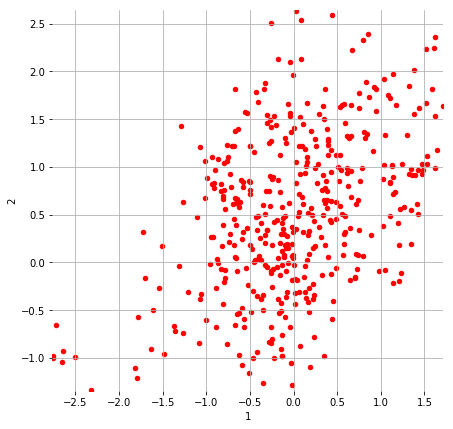

In [71]:
df_brahms.plot.scatter(1, 2, figsize=(7, 7), c = 'r')

Display a scatter plot of any two of the MFCC dimensions (i.e. columns of the data frame) against one another. Try for multiple pairs of MFCC dimensions.

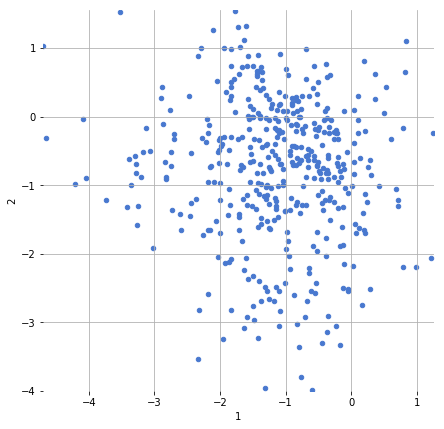

In [72]:
df_busta.plot.scatter(1, 2, figsize=(7, 7))

True


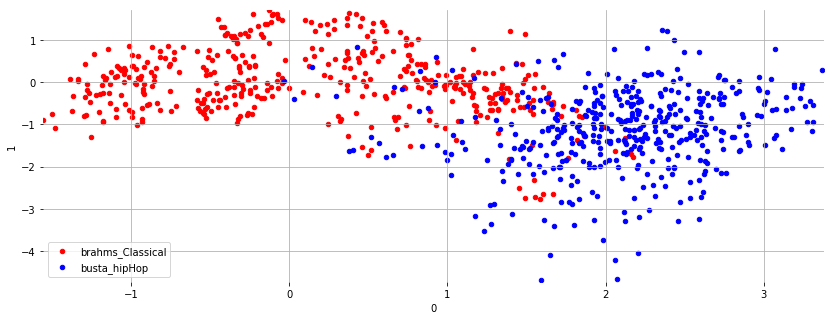

In [82]:
ax1 = df_brahms.plot(kind = 'scatter', x = 0, y = 1, c = 'r', label  = 'brahms_Classical' )
ax2 = df_busta.plot(kind = 'scatter', x = 0, y = 1, c = 'b', label  = 'busta_hipHop', ax = ax1 )

print (ax1 == ax2)

Plot a histogram of all values across a single MFCC, i.e. MFCC coefficient number. Repeat for a few different MFCC numbers:

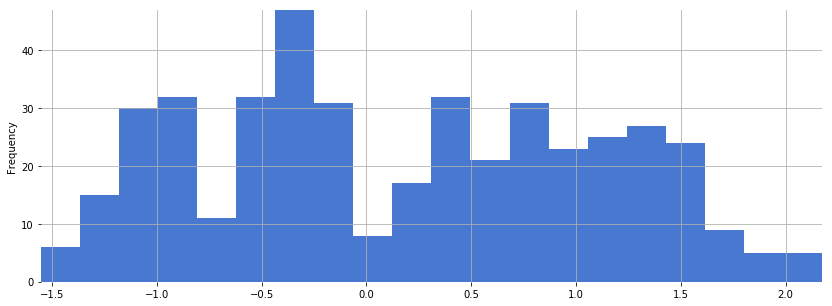

In [73]:
df_brahms[0].plot.hist(bins=20, figsize=(14, 5))

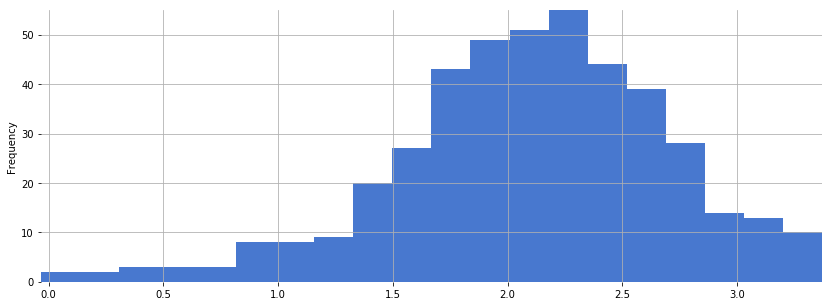

In [74]:
df_busta[0].plot.hist(bins=20, figsize=(14, 5))

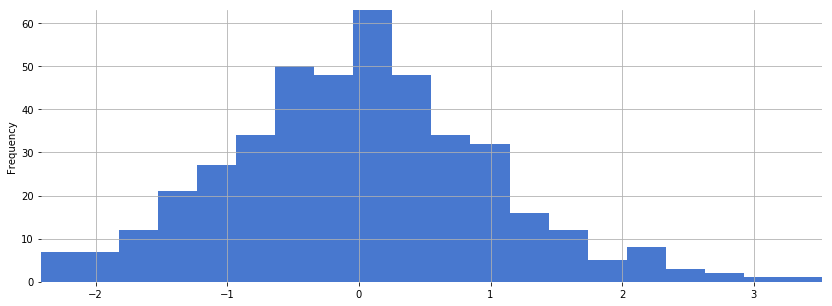

In [75]:
df_brahms[11].plot.hist(bins=20, figsize=(14, 5))

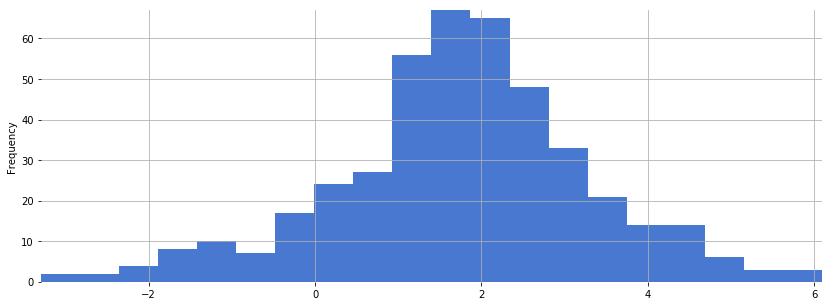

In [76]:
df_busta[11].plot.hist(bins=20, figsize=(14, 5))

[&larr; Back to Index](index.html)